# Exercise 8-1: Anomaly Detection 

In this exercise, we will implement the anomaly detection algorithm and apply it to detect failing servers on a network. 

## Part 1: Load Example Dataset

The `ex8data1.mat` contains a 2-D dataset.

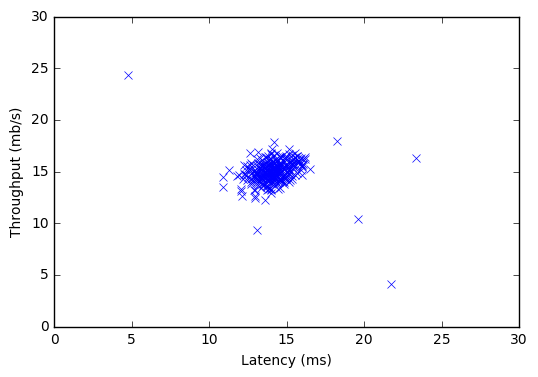

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt


mat_data = sio.loadmat('ex8data1.mat')
X = mat_data['X']
X_val = mat_data['Xval']
y_val = mat_data['yval'].ravel()

plt.figure()
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Part 2: Estimate the dataset statistics

The `estimate_gaussian()` estimates the parameters of a Gaussian distribution using the given data.

In [2]:
def estimate_gaussian(X):
    """
    Estimates the parameters of a Gaussian distribution using the data in X.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples and n_features is the number of features.

    Returns
    -------
    mu : ndarray, shape (n_feature,)
        The mean of each feature.
    sigma2 : ndarray, shape (n_feature,)
        The variance of each feature.
    """
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2


The `multivariate_gaussian()` computes the probability density function of the multivariate gaussian distribution.

In [3]:
def multivariate_gaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples and n_features is the number of features.
    mu : ndarray, shape (n_feature,)
        The mean of each feature.
    sigma2 : ndarray, shape (n_feature,)
        The variance of each feature.

    Returns
    -------
    p : ndarray, shape (n_samples,)
        The probability density function of the examples X under the multivariate gaussian distribution with parameters
        mu and Sigma2.
    """
    k = len(mu)

    if len(Sigma2.shape) == 1:
        Sigma2 = np.diag(Sigma2)

    X_mu = X - mu
    p = (2 * np.pi) ** (-k / 2.0) * np.linalg.det(Sigma2) ** (-0.5) \
        * np.exp(-0.5 * np.sum(X_mu.dot(np.linalg.pinv(Sigma2)) * X_mu, axis=1))

    return p


Estimate and visualize the fitted Gaussian distribution:

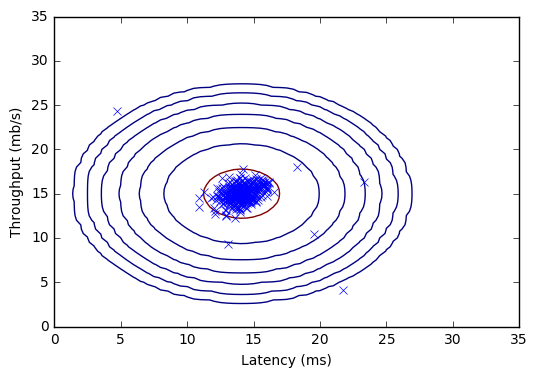

In [4]:
from visualize_fit import visualize_fit


# Estimate mu and sigma2
mu, sigma2 = estimate_gaussian(X)

# Returns the density of the multivariate normal at each data point (row) of X
p = multivariate_gaussian(X, mu, sigma2)

# Visualize the fit
plt.figure()
visualize_fit(X, mu, sigma2)
plt.xlim(0, 35)
plt.ylim(0, 35)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Part 3: Find Outliers

The `select_threshold()` finds the best threshold (epsilon) to use for selecting outliers.

In [5]:
def select_threshold(y_val, p_val):
    """
    Find the best threshold (epsilon) to use for selecting outliers.

    Parameters
    ----------
    y_val : ndarray, shape (n_samples,)
        Labels from validation set, where n_samples is the number of samples and n_features is the number of features.
    p_val : ndarray, shape (n_samples,)
        The probability density from validation set.

    Returns
    -------
    best_epsilon : numpy.float64
        The best threshold for selecting outliers.
    best_F1 : numpy.float64
        The best F1 score.
    """
    step_size = (np.max(p_val) - np.min(p_val)) / 1000

    best_epsilon = 0.0
    best_F1 = 0.0

    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        predictions = p_val < epsilon
        tp = np.sum(predictions[np.nonzero(y_val == True)])
        fp = np.sum(predictions[np.nonzero(y_val == False)])
        fn = np.sum(y_val[np.nonzero(predictions == False)] == True)
        if tp != 0:
            prec = 1.0 * tp / (tp + fp)
            rec = 1.0 * tp / (tp + fn)
            F1 = 2.0 * prec * rec / (prec + rec)
            if F1 > best_F1:
                best_F1 = F1
                best_epsilon = epsilon

    return best_epsilon, best_F1

Select the threshold based on a cross validation set:

Best epsilon found using cross-validation: 8.99085277927e-05
Best F1 on Cross Validation Set: 0.875
(you should see a value epsilon of about 8.99e-05)


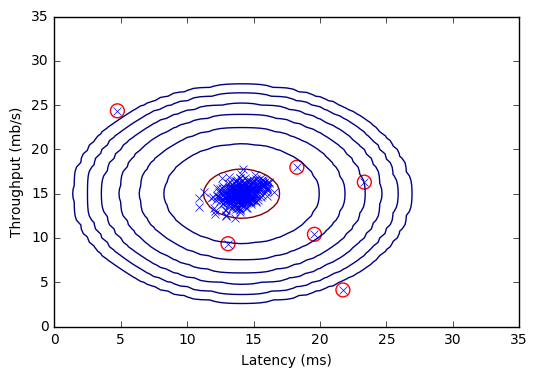

In [6]:
p_val = multivariate_gaussian(X_val, mu, sigma2)

epsilon, F1 = select_threshold(y_val, p_val)

print 'Best epsilon found using cross-validation:', epsilon
print 'Best F1 on Cross Validation Set:', F1
print '(you should see a value epsilon of about 8.99e-05)'

outliers = np.nonzero(p < epsilon)

plt.figure()
visualize_fit(X, mu, sigma2)
plt.scatter(X[outliers, 0], X[outliers, 1], facecolors='none', edgecolors='r', s=100)
plt.xlim(0, 35)
plt.ylim(0, 35)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Part 4: Multidimensional Outliers

In `ex8data2.mat`, each sample has 11 features. Apply anomaly detection algorithm on this multidimensional data: 

In [7]:
# Loads the second dataset.
mat_data = sio.loadmat('ex8data2.mat')
X = mat_data['X']
X_val = mat_data['Xval']
y_val = mat_data['yval'].ravel()

# Apply the same steps to the larger dataset
mu, sigma2 = estimate_gaussian(X)

# Training set
p = multivariate_gaussian(X, mu, sigma2)

# Cross-validation set
p_val = multivariate_gaussian(X_val, mu, sigma2)

# Find the best threshold
epsilon, F1 = select_threshold(y_val, p_val)

print 'Best epsilon found using cross-validation:', epsilon
print 'Best F1 on Cross Validation Set:', F1
print '# Outliers found:', np.sum(p < epsilon)
print '(you should see a value epsilon of about 1.38e-18)'

Best epsilon found using cross-validation: 1.37722889076e-18
Best F1 on Cross Validation Set: 0.615384615385
# Outliers found: 117
(you should see a value epsilon of about 1.38e-18)
